### Initialization

In [1]:
from pyspark import SparkContext

sc = SparkContext('local[*]')


import geomesa_pyspark

conf = geomesa_pyspark.configure(
        jars=['/jars/geomesa-fs-spark-runtime_2.11-2.4.0.jar'],
        packages=['geomesa_pyspark','pytz'],
        spark_home='/usr/local/spark/'
       ) \
       .setAppName('MyTestApp')


from pyspark.sql import SparkSession

spark = SparkSession \
        .builder \
        .config(conf=conf) \
        .enableHiveSupport() \
        .getOrCreate()

geomesa_pyspark.init_sql(spark)

### Spatial Join (Point to Polygon)

#### ST_Contains

In [2]:
from pyspark.sql import Row

from geomesa_pyspark.types import Point, Polygon

points = spark.createDataFrame([
    Row(pt=Point(5, 5)),
    Row(pt=Point(10, 10)),
    Row(pt=Point(20, 20)),
])
points.createOrReplaceTempView('pt')

polygon = spark.createDataFrame([
    Row(name='poly',
        geom=Polygon([
                Point(0, 0),
                Point(10, 0),
                Point(10, 10),
                Point(0, 10),
                Point(0, 0)
             ])
    ),
    Row(name='poly2',
        geom=Polygon([
                Point(10, 10),
                Point(100, 0),
                Point(100, 100),
                Point(10, 100),
                Point(10, 10)
             ])
    ),
])
polygon.createOrReplaceTempView('poly')

joined = spark.sql('''
    select * from pt
    left outer join poly
    on st_contains(poly.geom, pt.pt)
''')
joined.show()

+-------------+--------------------+-----+
|           pt|                geom| name|
+-------------+--------------------+-----+
|  POINT (5 5)|POLYGON ((0 0, 10...| poly|
|POINT (10 10)|                null| null|
|POINT (20 20)|POLYGON ((10 10, ...|poly2|
+-------------+--------------------+-----+



ポリゴンの境界線上にあるポイントは結合されていない。
![](images/spatial_join.png)

### 距離計算 (Point to Point)

#### ST_DistanceSphere, ST_DistanceSpheroid

In [3]:
from pyspark.sql import Row

from geomesa_pyspark.types import Point, Polygon, LineString

poi2poi_dist = spark.createDataFrame([
    Row(tokyo=Point(139.69167, 35.68944),
        osaka=Point(135.52, 34.68639)
    )
])
poi2poi_dist.createOrReplaceTempView('poi2poi')

'''
東京都と大阪府間の距離を算出
sphere : 球形の地球を想定した2つの緯度経度間の最小距離
sheroid: wGS84回転楕円体を想定した2つの緯度経度間の最小距離
euclid : 2つの座標間の平面距離
'''
spark.sql('''
    select
      st_distanceSphere(tokyo, osaka) as sphere,
      st_distanceSpheroid(tokyo, osaka) as spheroid,
      st_distance(tokyo, osaka) as euclid
    from poi2poi
''').show()

+-----------------+------------------+-----------------+
|           sphere|          spheroid|           euclid|
+-----------------+------------------+-----------------+
|395132.9370551306|395874.34253470233|4.290564052825666|
+-----------------+------------------+-----------------+



![](images/tokyo2osaka.png)

### 距離計算 (Point to Line, Point to Polygon)
#### ※ST_DistanceSphereやST_DistanceSpheroidの引数に、ラインやポリゴンを使用した場合、ユークリッド距離以外は最初の１点との距離が算出される模様。

In [4]:
from pyspark.sql import Row

from geomesa_pyspark.types import Point, Polygon, LineString

dist = spark.createDataFrame([
    Row(tokyo=Point(139.69167, 35.68944),
        osaka=Point(135.52, 34.68639),
        geom=Polygon([
              Point(139.69167, 35.68944),
              Point(135.52, 34.68639),
              Point(139.69167, 34.68639),
              Point(139.69167, 35.68944)
        ]),
        line=LineString([
              Point(139.69167, 35.68944),
              Point(135.52, 34.68639)
        ])
    )
])
dist.createOrReplaceTempView('dist')

'''
大阪府からポリゴン、大阪府からラインまでの距離を算出
sphere : 球形の地球を想定した2つの緯度経度間の最小距離
sheroid: wGS84回転楕円体を想定した2つの緯度経度間の最小距離
euclid : 2つの座標間の平面距離
'''
spark.sql('''
    select
      st_distanceSphere(osaka, geom) as sphere_to_geom,
      st_distanceSpheroid(osaka, geom) as spheroid_to_geom,
      st_distance(osaka, geom) as euclid_to_geom,
      st_distanceSphere(osaka, line) as sphere_to_line,
      st_distanceSpheroid(osaka, line) as spheroid_to_line,
      st_distance(osaka, line) as euclid_to_line
    from dist
''').show()

+-----------------+------------------+--------------+-----------------+------------------+--------------+
|   sphere_to_geom|  spheroid_to_geom|euclid_to_geom|   sphere_to_line|  spheroid_to_line|euclid_to_line|
+-----------------+------------------+--------------+-----------------+------------------+--------------+
|395132.9370551306|395874.34253470233|           0.0|395132.9370551306|395874.34253470233|           0.0|
+-----------------+------------------+--------------+-----------------+------------------+--------------+



#### euclid以外は東京都と大阪府の距離と同じ結果になっている。

![](images/osaka2polygon,line.png)

### 形式変換 (Point to Line)
#### LineString

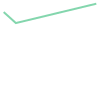

In [5]:
from geomesa_pyspark.types import Point, LineString

LineString([
    Point(139.69167, 35.68944),
    Point(135.52, 34.68639),
    Point(134.89, 35.255)
])